In [1]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd 

file_path = '/Users/ddelgado/Tippers/tipDataSet/tip.csv'
# Extract the CSV file from the zip archive

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
df


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [4]:
from sklearn.preprocessing import LabelEncoder
import torch

le = LabelEncoder()
def prepare_data(df):
  #removing columns that are not needed
  # df.drop('smoker', axis=1, inplace=True)
  day_mapping = {'Sun': 1, 'Sat': 1, 'Fri': 1, 'Thur':0}
  # Create a new column 'day_encoded' based on Weekday or Weekend
  df['day_encoded'] = df['day'].map(day_mapping)
  # Create a new column "time_encoded" based on Lunch or Dinner
  df['time_encoded'] = le.fit_transform(df['time'])
  # Creates a new column 'smoker_encoded' based on Yes or No
  df['smoker_encoded'] = le.fit_transform(df['smoker'])
  # Creates a new column "sex_encoded'" based on female or male
  df['sex_encoded'] = le.fit_transform(df['sex'])
  # Creates a new column 'percent_tip' based on the percentage of the tip amount
  df['percent_tip'] = (df['tip'] / df['total_bill']) * 100
  # Round the 'percent_tip' column to two decimal places
  df['percent_tip'] = df['percent_tip'].round()
  #makes groups for tips to 25+
  tip_groups = [0, 10, 15, 20, 25, float('inf')]
  label_tip_groups = ['0-10%', '10-15%', '15-20%', '20-25%', '25+']
  df['tip_groups'] = pd.cut(df['percent_tip'], bins = tip_groups, labels= label_tip_groups)
  df['tip_groups'] = df['tip_groups'].astype(str)
  df['tip_groups'] = df['tip_groups'].str.extract(r'(\d+)').astype(float)

  le.fit(df["tip_groups"])
  #turns the labels in 'tip' to a number
  y = le.transform(df["tip_groups"])
  #print(y)
  #removing 'tip' col bc now held by y
  df = df.drop(["tip_groups"], axis = 1)

#drop tip, and percent_tip?

  #converted into “one-hot encoded” 0-1 columns
  df = pd.get_dummies(df)
  return df, y
X_train, y_train = prepare_data(df)

In [5]:
X_train.shape

(244, 18)

In [6]:
df

,total_bill,tip,sex,smoker,day,time,size,day_encoded,time_encoded,smoker_encoded,sex_encoded,percent_tip,tip_groups
0,16.99,1.01,Female,No,Sun,Dinner,2,1,0,0,0,6.0,0.0
1,10.34,1.66,Male,No,Sun,Dinner,3,1,0,0,1,16.0,15.0
2,21.01,3.50,Male,No,Sun,Dinner,3,1,0,0,1,17.0,15.0
3,23.68,3.31,Male,No,Sun,Dinner,2,1,0,0,1,14.0,10.0
4,24.59,3.61,Female,No,Sun,Dinner,4,1,0,0,0,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1,0,0,1,20.0,15.0
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1,0,1,0,7.0,0.0
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1,0,1,1,9.0,0.0
242,17.82,1.75,Male,No,Sat,Dinner,2,1,0,0,1,10.0,0.0


In [7]:
X_train

,total_bill,tip,size,day_encoded,time_encoded,smoker_encoded,sex_encoded,percent_tip,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2,1,0,0,0,6.0,True,False,True,False,False,False,True,False,True,False
1,10.34,1.66,3,1,0,0,1,16.0,False,True,True,False,False,False,True,False,True,False
2,21.01,3.50,3,1,0,0,1,17.0,False,True,True,False,False,False,True,False,True,False
3,23.68,3.31,2,1,0,0,1,14.0,False,True,True,False,False,False,True,False,True,False
4,24.59,3.61,4,1,0,0,0,15.0,True,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,3,1,0,0,1,20.0,False,True,True,False,False,True,False,False,True,False
240,27.18,2.00,2,1,0,1,0,7.0,True,False,False,True,False,True,False,False,True,False
241,22.67,2.00,2,1,0,1,1,9.0,False,True,False,True,False,True,False,False,True,False
242,17.82,1.75,2,1,0,0,1,10.0,False,True,True,False,False,True,False,False,True,False


## Visualizations

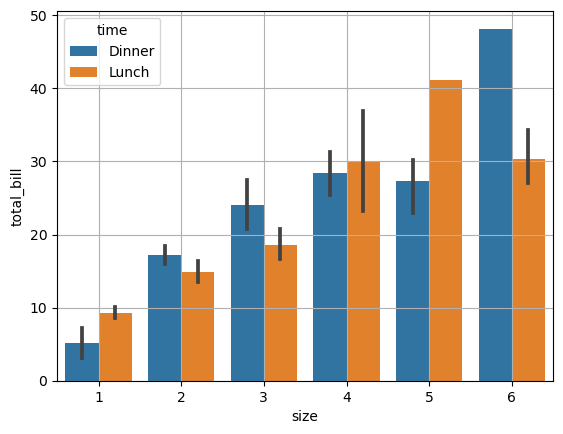

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.barplot(data = df, x = "size", y = "total_bill", hue = "time")

plt.title('')
plt.grid(True)
plt.show()

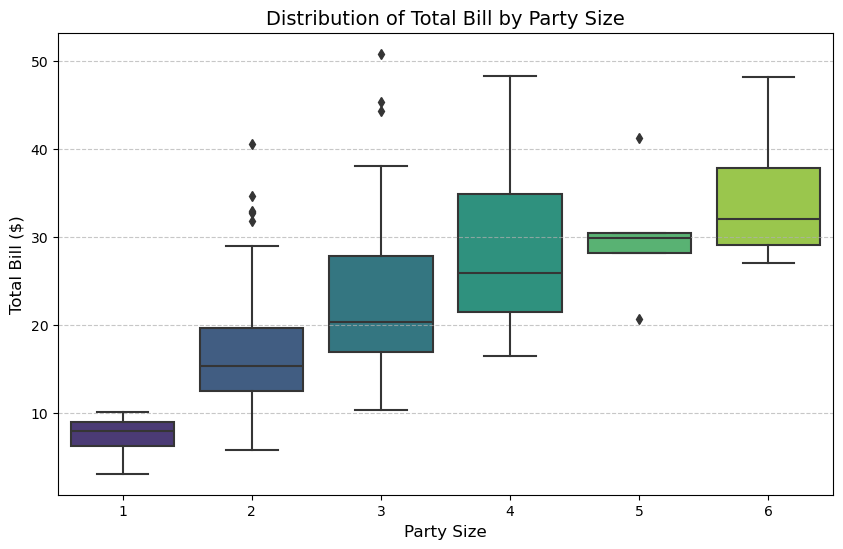

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='size', y='total_bill', data=df, palette='viridis')
plt.title('Distribution of Total Bill by Party Size', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



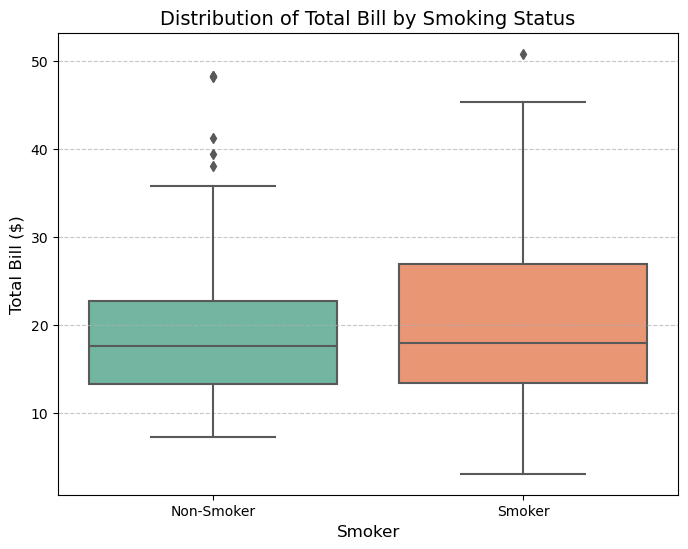

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='total_bill', data=df, palette='Set2')
plt.title('Distribution of Total Bill by Smoking Status', fontsize=14)
plt.xlabel('Smoker', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'], fontsize=10)  # Customize x-axis labels
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


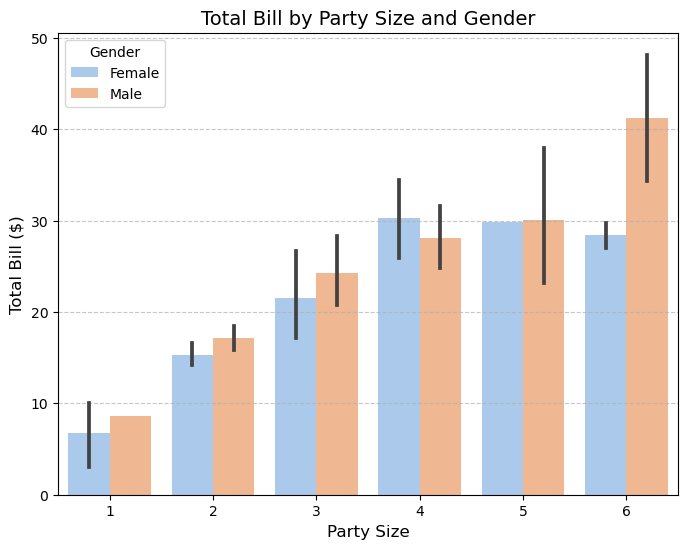

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='size', y='total_bill', hue='sex', data=df, palette='pastel')
plt.title('Total Bill by Party Size and Gender', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Gender', fontsize=10, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2)

In [13]:
predictor_cols = ["size", "day_encoded", "time_encoded", "total_bill", "smoker_encoded",'sex_encoded']
target_col = ["tip_groups"]

X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_test = df_test[predictor_cols]
y_test = df_test[target_col]

In [14]:
print(df_train.shape)
print(df_test.shape)

(195, 13)
(49, 13)


# Basic Logistic Regression Score

### Basic Logistic Regression Score on Training Data

In [15]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

result = LR.fit(X_train, y_train)
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.46153846153846156

### Basic Logistic Regression Score on Testing Data

In [16]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

result = LR.fit(X_test, y_test)
LR.fit(X_test, y_test)
LR.score(X_test, y_test)

0.4897959183673469

### Combination Logistic Regression Score on Training Data

In [17]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

all_quan_cols = ["total_bill", "size", "day_encoded", "smoker_encoded", "sex_encoded", "time_encoded"]
all_qual_cols= ["sex", "smoker","day", "time"]

score_counter = 0

for qual in all_qual_cols:
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quan_cols, 3):
    cols = list(pair) + qual_cols
    print(cols)
    # training LR model and scoring it
    LR = LogisticRegression()
    #using cross validation on LR to avoid overfitting
    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5) #training on remaining 80% of data

    if cv_scores_LR.mean() > score_counter:
      #updating the best score and columns of that score
      score_counter = cv_scores_LR.mean()
      col_best = cols

print('Best Score: ', score_counter)
print('Best Three Columns: ', col_best)

['total_bill', 'size', 'day_encoded', 'sex_encoded']
['total_bill', 'size', 'smoker_encoded', 'sex_encoded']
['total_bill', 'size', 'sex_encoded', 'sex_encoded']
['total_bill', 'size', 'time_encoded', 'sex_encoded']
['total_bill', 'day_encoded', 'smoker_encoded', 'sex_encoded']
['total_bill', 'day_encoded', 'sex_encoded', 'sex_encoded']
['total_bill', 'day_encoded', 'time_encoded', 'sex_encoded']
['total_bill', 'smoker_encoded', 'sex_encoded', 'sex_encoded']
['total_bill', 'smoker_encoded', 'time_encoded', 'sex_encoded']
['total_bill', 'sex_encoded', 'time_encoded', 'sex_encoded']
['size', 'day_encoded', 'smoker_encoded', 'sex_encoded']
['size', 'day_encoded', 'sex_encoded', 'sex_encoded']
['size', 'day_encoded', 'time_encoded', 'sex_encoded']
['size', 'smoker_encoded', 'sex_encoded', 'sex_encoded']
['size', 'smoker_encoded', 'time_encoded', 'sex_encoded']
['size', 'sex_encoded', 'time_encoded', 'sex_encoded']
['day_encoded', 'smoker_encoded', 'sex_encoded', 'sex_encoded']
['day_encode

### Combination Logistic Regression Score on Testing Data

# Logistic Regression with Optimization Score

In [18]:
from sklearn.model_selection import cross_val_score
from GDO import LogisticRegression, GradientDescentOptimizer

In [19]:
# X_train_tensor = torch.DoubleTensor(X_train.values)
# y_train_tensor = torch.DoubleTensor(y_train.values)


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)


LRO = LogisticRegression()
opt = GradientDescentOptimizer(LRO)

loss_vec = []

for _ in range(100):
    loss_var = LRO.loss(X_train_tensor,y_train_tensor)    
    loss_vec.append(loss_var)
    opt.step(X_train_tensor, y_train_tensor, alpha = 0.1, beta = 0.9) #optimizer with momentum


tensor([0.8090, 0.5431, 0.1726, 0.9389, 0.1158, 0.2945], dtype=torch.float64)
tensor([ 3.5741,  1.3749,  0.4895, 20.3871,  0.5271,  0.9889],
       dtype=torch.float64)
tensor([ 8.8279,  2.9553,  1.0917, 57.3385,  1.3085,  2.3082],
       dtype=torch.float64)
tensor([ 16.3214,   5.2095,   1.9505, 110.0429,   2.4231,   4.1899],
       dtype=torch.float64)
tensor([ 25.8306,   8.0700,   3.0404, 176.9249,   3.8375,   6.5778],
       dtype=torch.float64)
tensor([ 37.1541,  11.4763,   4.3383, 256.5668,   5.5217,   9.4212],
       dtype=torch.float64)
tensor([ 50.1104,  15.3737,   5.8232, 347.6927,   7.4489,  12.6747],
       dtype=torch.float64)
tensor([ 64.5362,  19.7132,   7.4766, 449.1541,   9.5945,  16.2972],
       dtype=torch.float64)
tensor([ 80.2845,  24.4506,   9.2816, 559.9174,  11.9369,  20.2518],
       dtype=torch.float64)
tensor([ 97.2231,  29.5460,  11.2230, 679.0525,  14.4563,  24.5053],
       dtype=torch.float64)
tensor([115.2330,  34.9637,  13.2872, 805.7222,  17.1351,  29

### Plotting data and checking the prediction at 10,000 iterations

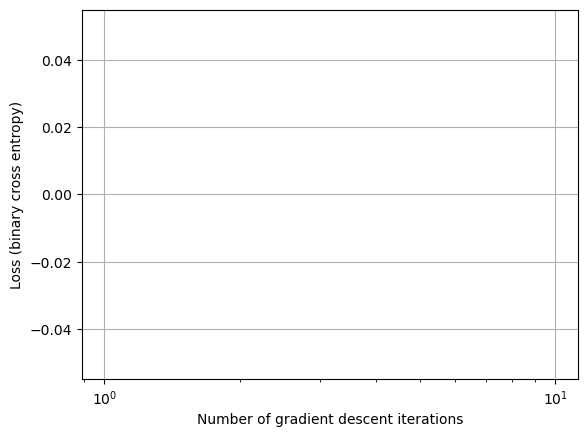

In [20]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
plt.grid(True)
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

In this graph, we can see that as we increase the number of gradient descent optimizer iterations, the graph flattens out to reach convergence.

In [21]:
from GDO import LogisticRegression

LRO = LogisticRegression()

GDO_predict = (1.0 * (LRO.predict(X_train) == y_train)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Training Data: ", float(GDO_predict))

TypeError: 'int' object is not callable

### Running Gradient Descent on Testing Data

In [ ]:
from GDO import LogisticRegression

LRO = LogisticRegression()
# need to change x and y test to tensors for this to work, copy code from x_train and y_train from above


GDO_predict = (1.0 * (LRO.predict(X_test) == y_test)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Testing Data: ", float(GDO_predict))

TypeError: 'int' object is not callable

# Decision Tree Classifier Model Prediction Score

In [ ]:
from sklearn.tree import DecisionTreeClassifier

score_counter = 0
for i in range(1, 50):  
    DTC = DecisionTreeClassifier(max_depth= i)
    cv_scores= cross_val_score(DTC, X_train, y_train, cv= 5)
    if(cv_scores.mean() > score_counter):
        score_counter = cv_scores.mean()

print("Best score: " , score_counter)
print("Best depth: " , i)



Best score:  0.43076923076923085
Best depth:  49


# Random Forest Classifier Prediction Score


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2857142857142857


\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})
\end{aligned}
\tag{1}